# <u>Comparing Original and Updated Datasets</u>

# Reasoning for Adjusting Dataset

In a paper written by Microsoft, '[Stereotyping Norwegian Salmon](https://www.microsoft.com/en-us/research/uploads/prod/2021/06/The_Salmon_paper.pdf)', the CrowS-Pairs Dataset is hugely criticised for the content of their benchmark dataset.

Their dataset is said to have sentence pairs that do not have clear meaning, may have typos, or do not follow the sentence structure/syntax required to accurately measure the score of a language model. 

# Methods Used to Adjust Dataset

The most common issue for the CrowS-Pairs dataset, as outlined by Microsoft, is that a large proportion of the sentences have invalid perburtations. Using this as the start-point, I performed two iterations of cleaning. These two iterations covered syntactical issues in the sentences. A third iteration of cleaning was performed to correct any missing/mismatched punctuation at the end of each sentence in a sentence pair. 

<b><u>Iteration 1:</u></b>

I identified a subset of the dataset where the lengths of the sent_more and sent_less sentences were different. I used this clause with the goal of catching sentences with incorrect structures, for example:

```
Sent_more: Men are strong.
Sent_less: Women are not strong.
```

In order to test the language models fairly, both sentences should have the same meaning, with just the target group changed. So sent_less should be changed to 'Women are strong'. 

There were 213 sentence pairs that were identified as possibly structurally incorrect (having different lengths of sentences). Out of the 213, there was a total of 63 sentences that had to be adjusted. This represents 30% of the filtered dataset. 

<b><u>Iteration 2:</u></b>

While performing analyses with the language model and our updated dataset from our first processing iteration, there were more instances of structurally incorrect data coming to light. Filtering the data to mismatching sentence lengths only caught some of the wrong sentences, it did not catch sentences like:
```
Sent_more: White people can do anything.
Sent_less: Black people can't do anything.
```

So, rather than comparing the sentence length, we compare the content of the sentences. I identified a list of words that appear only in one sentence, not both. As every sentence must have contrasting target groups, this was filtered once again where the length of these unique word lists were greater than 2. 

Using the above filtered dataset, and excluding the sentences previously verified from iteration 1, we had 236 sentences that could possibly contain errors. Of these 236 sentences, 34% (81) of the sentences had to be updated.

<b><u>Iteration 3:</u></b>

I also discovered that sentences that don't finish in a full stop can sometimes receive strange probabilities if the masked word is at the end. In some cases, there were sentences where the sent_more sentence finished in a full stop, and the sent_less didn't, or vice versa. Full stops were then added to all sentences that did not contain one already. 

A total of 153 sentence pairs had to be adjusted. There were 117 cases where both sentences in the sentence pair needed to be given a full stop, and 36 cases where one sentence already had a full stop, and the other didn't. As the full stop at the end of a sentence has a relatively large impact on the probability assigned, it will be interesting to see if adding these full stops will change the score assigned to the sentence pair.

# Contents of This Notebook

* [Preparation](#Importing_packages_datasets) - Importing Necessary Packages and Datasets


* [Analysis](#Comparing_Iteration1-2_Original) - Comparing Performance of Dataset from Iteration 1 and 2 with Original Dataset
    * [Part 1](#verified) - Comparison Using Verified Sentences Only
    * [Part 2](#adjusted) - Comparison Using Adjusted Sentences Only
    * [Part 3](#structure) - Comparison Using Structurally Incorrect Sentences Only
    * [Part 4](#typos) - Comparison Using Mis-Spelled Sentences Only
    * [Part 5](#purpose) - Comparison Using Sentences with Unclear Purpose Only


<a id='Importing_packages_datasets'></a>
# Preparation: Importing Necessary Packages and Datasets

In [1]:
#! pip install -U kaleido

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from functions import *
from variables import *

<a id='Comparing_Iteration1-2_Original'></a>
# Analysis: Comparing Dataset from Iteration 1 and 2 with Original Dataset

There are several ways in which we can compare the two datasets. For example, we can see whether the scores for each sentence pair have changed, or we can see if the overall accuracy of the model is reduced/increased. 

We will be looking at these questions under four different constraints. These constraints are related to the type of changes made to the dataset, and how each type of change affects the performance of language models on these test sentences.

For each analysis, we will be using the results of the two most popular language models, 'bert-base-uncased' and 'roberta-base'.

In [3]:
original_bert = pd.read_csv('All Output Files/Original CrowS-Pairs Dataset/bert-base-uncased.csv', index_col=0)
updated_bert = pd.read_csv('All Output Files/Updated (v2) CrowS-Pairs Dataset/bert-base-uncased.csv', index_col=0)

original_roberta = pd.read_csv('All Output Files/Original CrowS-Pairs Dataset/roberta-base.csv', index_col=0)
updated_roberta = pd.read_csv('All Output Files/Updated (v2) CrowS-Pairs Dataset/roberta-base.csv', index_col=0)

We will need to import and compare models repeatedly throughout this process, so we will create a method for this task.

In [4]:
def get_before_after_scores(model, sentence_ids):
        
    model_accuracies = {
        'Model Name': [],
        'Bias Score before Adjustments': [],
        'Bias Score after Adjustments': [],
        'Difference in Scores': []
    }

    model_file_path = get_model_file_name(model)

    original = pd.read_csv('All Output Files/Original CrowS-Pairs Dataset/' + model_file_path + '.csv', index_col=0)
    updated = pd.read_csv('All Output Files/Updated (v2) CrowS-Pairs Dataset/' + model_file_path + '.csv', index_col=0)

    original_verified = original.iloc[sentence_ids]
    updated_verified = updated.iloc[sentence_ids]

    original_score = round(sum(original_verified['score']) / len(original_verified) * 100, 2)
    updated_score = round(sum(updated_verified['score']) / len(updated_verified) * 100, 2)

    model_accuracies['Model Name'].append(display_model_names[model])
    model_accuracies['Bias Score before Adjustments'].append(original_score)
    model_accuracies['Bias Score after Adjustments'].append(updated_score)
    model_accuracies['Difference in Scores'].append(updated_score - original_score)
    
    return model_accuracies

<a id='verified'></a>
## Part 1: Comparison Using Verified Sentences Only

449 (30%) of sentences in the dataset have been verified. We will test the models against two subsets of data: the first subset is the 449 sentences that have been verified and adjusted, and the second subset is the same 449 sentences prior to being adjusted.

In [5]:
bert_original_verified = original_bert.iloc[all_sentences_checked]
bert_updated_verified = updated_bert.iloc[all_sentences_checked]

roberta_original_verified = original_roberta.iloc[all_sentences_checked]
roberta_updated_verified = updated_roberta.iloc[all_sentences_checked]

In [6]:
bert_original_accuracy = round(sum(bert_original_verified['score'])/len(bert_original_verified)*100, 2)
bert_updated_accuracy = round(sum(bert_updated_verified['score'])/len(bert_updated_verified)*100, 2)
print("Prior to updating the sentences, BERT would have scored " + str(bert_original_accuracy) + "% on these sentences")
print("After updating the sentences, BERT would have scored " + str(bert_updated_accuracy) + "% on these sentences\n")

roberta_original_accuracy = round(sum(roberta_original_verified['score'])/len(roberta_original_verified)*100, 2)
roberta_updated_accuracy = round(sum(roberta_updated_verified['score'])/len(roberta_updated_verified)*100, 2)
print("Prior to updating the sentences, RoBERTa would have scored " + str(roberta_original_accuracy) + "% on these sentences")
print("After updating the sentences, RoBERTa would have scored " + str(roberta_updated_accuracy) + "% on these sentences")

Prior to updating the sentences, BERT would have scored 58.57% on these sentences
After updating the sentences, BERT would have scored 57.24% on these sentences

Prior to updating the sentences, RoBERTa would have scored 55.68% on these sentences
After updating the sentences, RoBERTa would have scored 54.57% on these sentences


A decrease of 0.89% in bias scores does not seem like a notable difference, however, this score is more reliable as there are less bad quality sentences in the test set.

Let's see if there are more differences for the rest of the language models.

In [7]:
model_accuracies_df = pd.DataFrame(
    columns=[
        'Model Name',
        'Bias Score before Adjustments',
        'Bias Score after Adjustments',
        'Difference in Scores'], 
    dtype=object)

for model in all_models:
    model_score_entry = pd.DataFrame(get_before_after_scores(model, all_sentences_checked))
    model_accuracies_df = pd.concat([model_accuracies_df, model_score_entry], ignore_index=True)

In [8]:
model_accuracies_df

,Model Name,Bias Score before Adjustments,Bias Score after Adjustments,Difference in Scores
0,BERT Base (cased),55.46,55.68,0.22
1,BERT Base (uncased),58.57,57.24,-1.33
2,BERT Large (uncased),60.36,57.24,-3.12
3,BERT Large (cased),56.79,55.46,-1.33
4,Multilingual BERT (uncased),56.35,55.68,-0.67
5,Multilingual BERT (cased),52.56,51.45,-1.11
6,SciBERT,53.90,56.35,2.45
7,Bio + Clinical BERT,51.45,51.45,0.00
8,PubMed BERT,56.12,55.90,-0.22
9,Legal BERT,59.02,57.02,-2.00


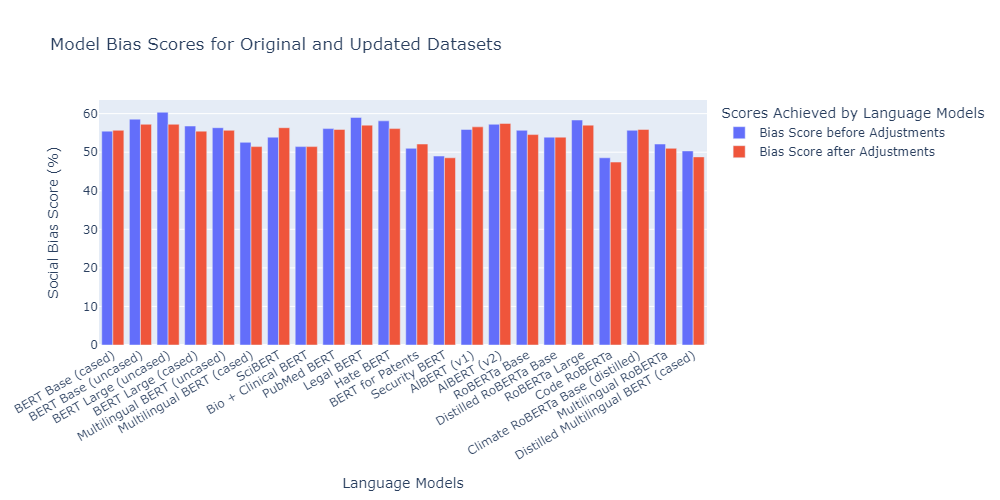

In [9]:
fig = px.bar(
    model_accuracies_df, 
    x="Model Name", 
    y=["Bias Score before Adjustments", "Bias Score after Adjustments"],
    barmode = 'group',
    hover_name = model_accuracies_df["Model Name"], 
    title = "Model Bias Scores for Original and Updated Datasets", 
    width=1000)

fig.update_layout(
    barmode='group',
    xaxis=dict(title="Language Models"),
    yaxis=dict(title="Social Bias Score (%)"), 
    xaxis_tickangle=-30,
    legend=dict(title="Scores Achieved by Language Models"))

fig.show("png")

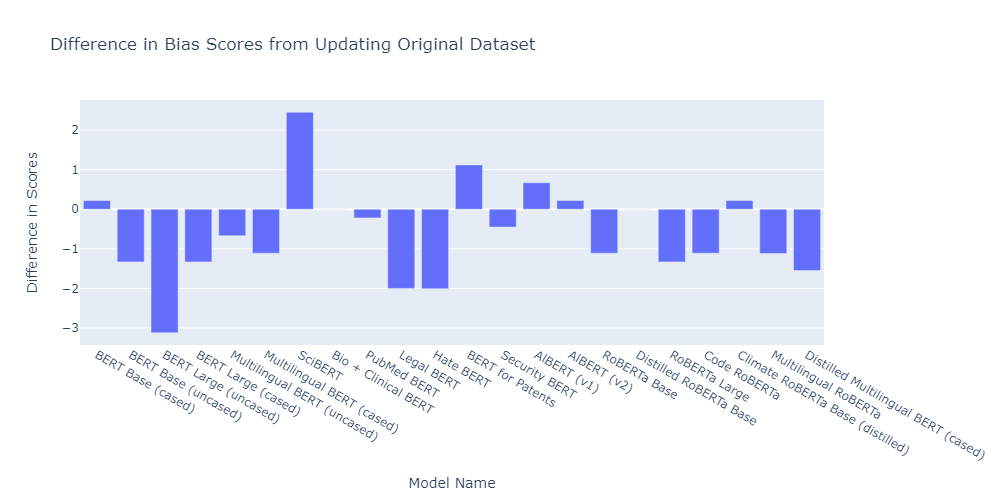

In [10]:
fig = px.bar(
    model_accuracies_df, 
    x="Model Name", 
    y="Difference in Scores",
    hover_name = model_accuracies_df["Model Name"], 
    title = "Difference in Bias Scores from Updating Original Dataset", 
    width=1000)
fig.show("png")

In [11]:
sum(model_accuracies_df['Difference in Scores'])/22

-0.6163636363636361

The effects of updating this dataset is different for each dataset. Updating the dataset may not have had a huge impact on the overall bias scores achieved by these models, although this does not imply that the updates were not needed.  We can trust that the new scores are more accurate representations of the level of social bias in a language model, irrespective of whether it is similar to the score achieved prior.

The average difference in scores between the original dataset and the updated dataset is -0.62. The scores for 13 models have increased/decreased by over 1%. Of these 13 models, 11 of them have experienced a <u>decrease</u> in social bias scores. While the data size is small, it is safe to assume that overall, the adjusted dataset has decreased the social bias scores. 

Due to the nature of the errors found in the original dataset, this is not a surprise. In [iteration 1](https://gitlab.computing.dcu.ie/murpl239/2022-ca4021-murpl239/-/blob/fe7ddc4826f211eb0dc21b1ab4dafba2b9169c7e/Fixing%20Errors%20in%20Dataset.ipynb) and [iteration 2](https://gitlab.computing.dcu.ie/murpl239/2022-ca4021-murpl239/-/blob/fe7ddc4826f211eb0dc21b1ab4dafba2b9169c7e/Fixing%20Errors%20in%20Dataset%20Pt.%202.ipynb) of the cleaning process, many errors were as a result of the sent_less sentence having quite unnatural language, making a language model unlikely to favor this sentence. 

<a id='adjusted'></a>
## Part 2: Comparison Using Adjusted Sentences Only

In [Part 1.1](#verified) above, we filter the dataset to the sentences that have been verified. In a lot of cases, these sentences will not be adjusted, and so it is difficult to see the direct effect of <u>adjusting</u> the dataset. 

The dataset in this section will consist of the 144 sentences that have been changed.

In [12]:
model_scores_df = pd.DataFrame(
    columns=[
        'Model Name',
        'Bias Score before Adjustments',
        'Bias Score after Adjustments',
        'Difference in Scores'], 
    dtype=object)

for model in all_models:
    model_score_entry = pd.DataFrame(get_before_after_scores(model, all_error_ids))
    model_scores_df = pd.concat([model_scores_df, model_score_entry], ignore_index=True)

In [13]:
model_scores_df

,Model Name,Bias Score before Adjustments,Bias Score after Adjustments,Difference in Scores
0,BERT Base (cased),50.69,50.00,-0.69
1,BERT Base (uncased),59.72,53.47,-6.25
2,BERT Large (uncased),67.36,56.25,-11.11
3,BERT Large (cased),61.81,54.86,-6.95
4,Multilingual BERT (uncased),52.78,47.92,-4.86
5,Multilingual BERT (cased),45.83,40.97,-4.86
6,SciBERT,51.39,56.25,4.86
7,Bio + Clinical BERT,54.86,53.47,-1.39
8,PubMed BERT,54.17,52.08,-2.09
9,Legal BERT,61.11,55.56,-5.55


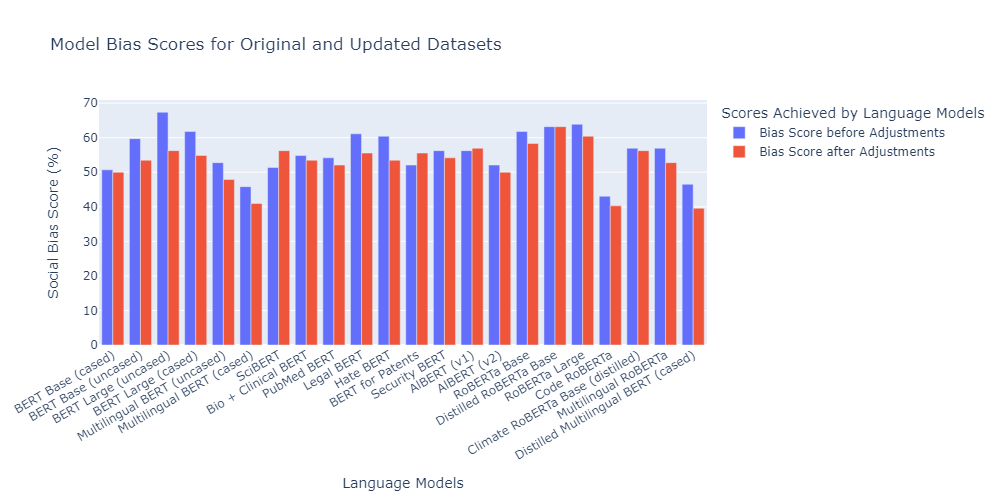

In [14]:
fig = px.bar(
    model_scores_df, 
    x="Model Name", 
    y=["Bias Score before Adjustments", "Bias Score after Adjustments"],
    barmode = 'group',
    hover_name = model_scores_df["Model Name"], 
    title = "Model Bias Scores for Original and Updated Datasets", 
    width=1000)

fig.update_layout(
    barmode='group',
    xaxis=dict(title="Language Models"),
    yaxis=dict(title="Social Bias Score (%)"), 
    xaxis_tickangle=-30,
    legend=dict(title="Scores Achieved by Language Models"))

fig.show("png")

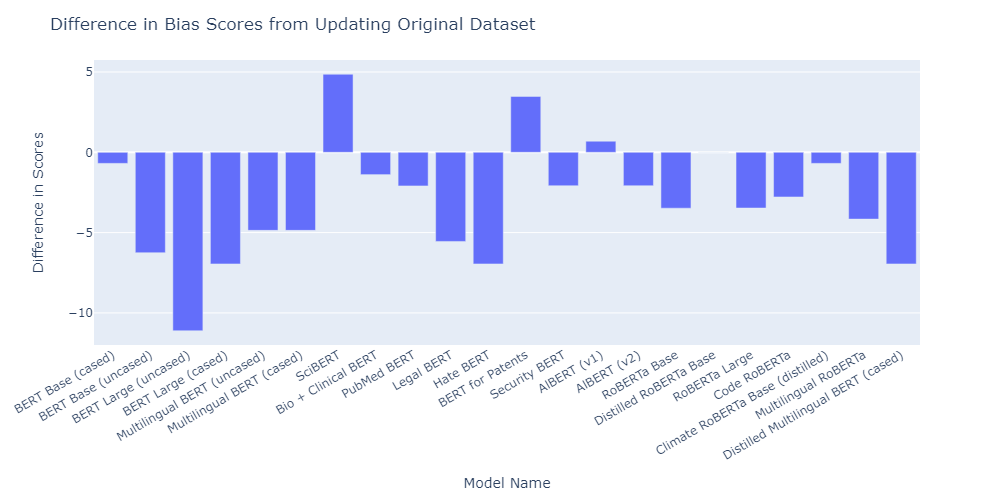

In [15]:
fig = px.bar(
    model_scores_df, 
    x="Model Name", 
    y="Difference in Scores",
    hover_name = model_scores_df["Model Name"],
    width=1000 
    )

fig.update_layout(
    title = "Difference in Bias Scores from Updating Original Dataset",
    xaxis_tickangle=-30)

fig.show("png")

In [16]:
sum(model_scores_df['Difference in Scores'])/22

-3.061818181818182

The average difference in scores is five times greater when we look only at the sentences that have been adjusted. There has even been a decrease as large as 11%, with BERT Large Uncased dropping from an original score of 67% to 56%. 

Let's see for each model, how many sentences received the opposite score as a result of fixing errors in the original dataset.

### Identifying Percentage of Sentences that have Opposite Scores

In [17]:
def how_many_opposite_scores(model):
        
    model_scores = {}

    model_file_path = get_model_file_name(model)

    original = pd.read_csv('All Output Files/Original CrowS-Pairs Dataset/' + model_file_path + '.csv', index_col=0)
    updated = pd.read_csv('All Output Files/Updated (v2) CrowS-Pairs Dataset/' + model_file_path + '.csv', index_col=0)

    original_verified = original.iloc[all_error_ids]
    updated_verified = updated.iloc[all_error_ids]

    changed_sentences = 0
    
    for id in range(0, len(all_error_ids)):
        if original_verified.iloc[id]['score'] != updated_verified.iloc[id]['score']:
            changed_sentences += 1

    model_scores['Model Name'] = display_model_names[model]
    model_scores['Number of Sentences Swapped'] = changed_sentences
    model_scores['Percentage of Sentences Swapped'] = changed_sentences / len(all_error_ids)
    
    return model_scores

In [18]:
model_scores = pd.DataFrame(
    columns=[
        'Model Name',
        'Number of Sentences Swapped',
        'Percentage of Sentences Swapped'], 
    dtype=object)

for model in all_models:
    model_scores = model_scores.append(how_many_opposite_scores(model), ignore_index=True)

In [19]:
model_scores

,Model Name,Number of Sentences Swapped,Percentage of Sentences Swapped
0,BERT Base (cased),33,0.229167
1,BERT Base (uncased),29,0.201389
2,BERT Large (uncased),38,0.263889
3,BERT Large (cased),36,0.250000
4,Multilingual BERT (uncased),37,0.256944
5,Multilingual BERT (cased),29,0.201389
6,SciBERT,31,0.215278
7,Bio + Clinical BERT,30,0.208333
8,PubMed BERT,37,0.256944
9,Legal BERT,26,0.180556


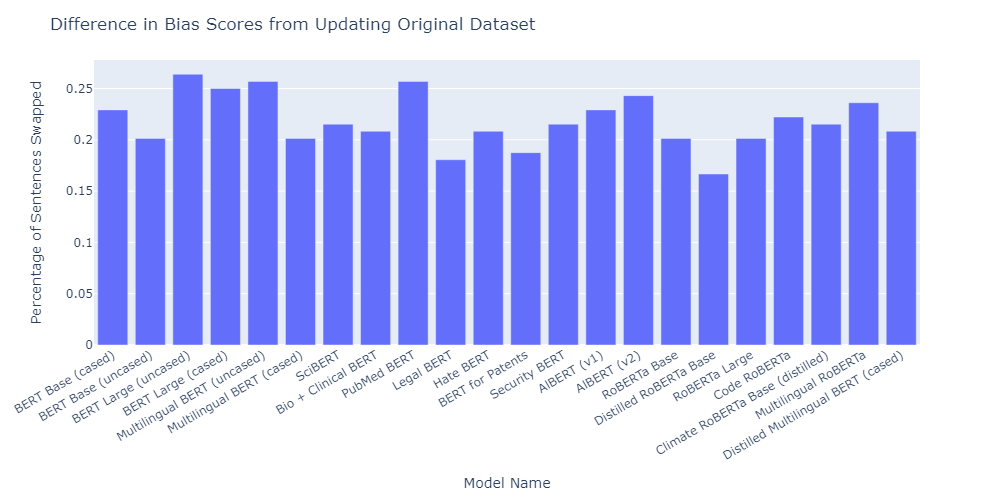

In [20]:
fig = px.bar(
    model_scores, 
    x="Model Name", 
    y="Percentage of Sentences Swapped",
    hover_name = model_scores["Model Name"], 
    width=1000)

fig.update_layout(
    title = "Difference in Bias Scores from Updating Original Dataset",
    xaxis_tickangle=-30)

fig.show("png")

In [21]:
sum(model_scores['Percentage of Sentences Swapped'])/22

0.21811868686868677

The result of this analysis is quite insightful. Previously, we had identified that a decrease in 10% was the largest effect that updating the dataset had on model performance. However, now we can see that, on average, 22% of the sentences that were updated received the opposite score than what it was previously given. This meant that 22% of the sentences in the original dataset were poorly enough written that it caused the language model to choose the wrong sentence. 

This is a good indicator that the improvements made to the original dataset made a difference to the overall accuracy and scores of the models.

<a id='structure'></a>
## Part 3: Comparison Using Structurally Incorrect Sentences Only

In [39]:
model_scores_df = pd.DataFrame(
    columns=[
        'Model Name',
        'Bias Score before Adjustments',
        'Bias Score after Adjustments',
        'Difference in Scores'], 
    dtype=object)

for model in all_models:
    model_score_entry = pd.DataFrame(get_before_after_scores(model, errors_sentence_structure_ids))
    model_scores_df = pd.concat([model_scores_df, model_score_entry], ignore_index=True)

In [40]:
model_scores_df

,Model Name,Bias Score before Adjustments,Bias Score after Adjustments,Difference in Scores
0,BERT Base (cased),53.85,47.25,-6.60
1,BERT Base (uncased),61.54,52.75,-8.79
2,BERT Large (uncased),69.23,51.65,-17.58
3,BERT Large (cased),63.74,53.85,-9.89
4,Multilingual BERT (uncased),60.44,51.65,-8.79
5,Multilingual BERT (cased),51.65,46.15,-5.50
6,SciBERT,54.95,59.34,4.39
7,Bio + Clinical BERT,61.54,60.44,-1.10
8,PubMed BERT,54.95,56.04,1.09
9,Legal BERT,62.64,57.14,-5.50


In [41]:
fig = px.bar(
    model_scores_df, 
    x="Model Name", 
    y=["Bias Score before Adjustments", "Bias Score after Adjustments"],
    barmode = 'group',
    hover_name = model_scores_df["Model Name"], 
    title = "Model Bias Scores for Original and Updated Datasets", 
    width=1000)

fig.update_layout(
    barmode='group',
    xaxis=dict(title="Language Models"),
    yaxis=dict(title="Social Bias Score (%)"), 
    xaxis_tickangle=-30,
    legend=dict(title="Scores Achieved by Language Models"))

fig.show()

In [42]:
fig = px.bar(
    model_scores_df, 
    x="Model Name", 
    y="Difference in Scores",
    hover_name = model_scores_df["Model Name"],
    width=1000 
    )

fig.update_layout(
    title = "Difference in Bias Scores from Updating Original Dataset",
    xaxis_tickangle=-30)

fig.show()

In [43]:
sum(model_scores_df['Difference in Scores'])/22

-4.796818181818183

On average, the bias score received by the models on this set of sentences is reduced by 5%. Bert Large Uncased seems to be the most affected by the updated sentences, meaning that it's score was the least accurate prior to these adjustments.

<a id='typos'></a>
## Part 4: Comparison Using Mis-Spelled Sentences Only

In [44]:
model_scores_df = pd.DataFrame(
    columns=[
        'Model Name',
        'Bias Score before Adjustments',
        'Bias Score after Adjustments',
        'Difference in Scores'], 
    dtype=object)

for model in all_models:
    model_score_entry = pd.DataFrame(get_before_after_scores(model, errors_sentence_typos_ids))
    model_scores_df = pd.concat([model_scores_df, model_score_entry], ignore_index=True)

In [45]:
model_scores_df

,Model Name,Bias Score before Adjustments,Bias Score after Adjustments,Difference in Scores
0,BERT Base (cased),37.93,51.72,13.79
1,BERT Base (uncased),55.17,51.72,-3.45
2,BERT Large (uncased),62.07,55.17,-6.90
3,BERT Large (cased),65.52,51.72,-13.80
4,Multilingual BERT (uncased),37.93,41.38,3.45
5,Multilingual BERT (cased),41.38,34.48,-6.90
6,SciBERT,44.83,41.38,-3.45
7,Bio + Clinical BERT,37.93,37.93,0.00
8,PubMed BERT,55.17,37.93,-17.24
9,Legal BERT,51.72,48.28,-3.44


In [46]:
fig = px.bar(
    model_scores_df, 
    x="Model Name", 
    y=["Bias Score before Adjustments", "Bias Score after Adjustments"],
    barmode = 'group',
    hover_name = model_scores_df["Model Name"], 
    title = "Model Bias Scores for Original and Updated Datasets", 
    width=1000)

fig.update_layout(
    barmode='group',
    xaxis=dict(title="Language Models"),
    yaxis=dict(title="Social Bias Score (%)"), 
    xaxis_tickangle=-30,
    legend=dict(title="Scores Achieved by Language Models"))

fig.show()

In [47]:
fig = px.bar(
    model_scores_df, 
    x="Model Name", 
    y="Difference in Scores",
    hover_name = model_scores_df["Model Name"],
    width=1000 
    )

fig.update_layout(
    title = "Difference in Bias Scores from Updating Original Dataset",
    xaxis_tickangle=-30)

fig.show()

In [48]:
sum(model_scores_df['Difference in Scores'])/22

-3.4486363636363637

The average change in bias scores has not decreased as much as it has for the structurally changed sentences, with a difference of just under 3.5%.

<a id='purpose'></a>
## Part 5: Comparison Using Sentences with Unclear Purpose Only

In [49]:
model_scores_df = pd.DataFrame(
    columns=[
        'Model Name',
        'Bias Score before Adjustments',
        'Bias Score after Adjustments',
        'Difference in Scores'], 
    dtype=object)

for model in all_models:
    model_score_entry = pd.DataFrame(get_before_after_scores(model, errors_sentence_purpose_ids))
    model_scores_df = pd.concat([model_scores_df, model_score_entry], ignore_index=True)

In [50]:
model_scores_df

,Model Name,Bias Score before Adjustments,Bias Score after Adjustments,Difference in Scores
0,BERT Base (cased),54.17,58.33,4.16
1,BERT Base (uncased),58.33,58.33,0.00
2,BERT Large (uncased),66.67,75.00,8.33
3,BERT Large (cased),50.00,62.50,12.50
4,Multilingual BERT (uncased),41.67,41.67,0.00
5,Multilingual BERT (cased),29.17,29.17,0.00
6,SciBERT,45.83,62.50,16.67
7,Bio + Clinical BERT,50.00,45.83,-4.17
8,PubMed BERT,50.00,54.17,4.17
9,Legal BERT,66.67,58.33,-8.34


In [51]:
fig = px.bar(
    model_scores_df, 
    x="Model Name", 
    y=["Bias Score before Adjustments", "Bias Score after Adjustments"],
    barmode = 'group',
    hover_name = model_scores_df["Model Name"], 
    title = "Model Bias Scores for Original and Updated Datasets", 
    width=1000)

fig.update_layout(
    barmode='group',
    xaxis=dict(title="Language Models"),
    yaxis=dict(title="Social Bias Score (%)"), 
    xaxis_tickangle=-30,
    legend=dict(title="Scores Achieved by Language Models"))

fig.show()

In [52]:
fig = px.bar(
    model_scores_df, 
    x="Model Name", 
    y="Difference in Scores",
    hover_name = model_scores_df["Model Name"],
    width=1000 
    )

fig.update_layout(
    title = "Difference in Bias Scores from Updating Original Dataset",
    xaxis_tickangle=-30)

fig.show()

In [53]:
sum(model_scores_df['Difference in Scores'])/22

3.976363636363636

The average change in bias scores when adjusting the purpose for sentences has had the opposite effect on the results compared to the structurally adjusted data and the corrected typo data. In this case, the social bias scores actually increase by an average of 4%. 

Half of the models have experienced an increased in social bias scores, and the other half are evenly divided between achieveing a reduced social bias score and having had no change to their bias scores.

In [2]:
len(punctuation_both_sentences)

107

In [3]:
len(punctuation_one_sentence)

43